In [16]:
from processing.DataLoader import DataLoaderFactory
from processing.AlignerBuilder import *
from processing.Optimizer import *

In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Generación aleatoria de secuencias de aminoácidos

Lo primero que hacemos es generar automáticamente dos secuencias aleatorias de aminoácidos de longitudes 70 y 65. Estas secuencias se generan a partir de una lista de aminoácidos predefinida, y se escoge aleatoriamente un aminoácido de la lista para cada posición de la secuencia.

In [18]:
sequenceLoader = DataLoaderFactory.get_loader("random")

In [19]:
sequence1 = sequenceLoader.load(50)
sequence2 = sequenceLoader.load(50)

print(f"Sequence 1: {sequence1}")
print(f"Sequence 2: {sequence2}")

Sequence 1: EYHMYEVMPSWYMPCDAESEIGMVYMTKAHFPYQSPDNPGGWNFALWCWL
Sequence 2: YVQGTIWCWGMTSHYFLGSVLHHYECWNLAPARQFISFDEGNINFMYGQP


### Alineamiento de secuencias con ajuste manual

A continuación, generamos un alineador de secuencias, asignándole algunos valores de penalización y recompensa para la función de alineamiento. Luego, alineamos las dos secuencias generadas anteriormente y mostramos el resultado.

In [20]:
aligner = AlignerBuilder().build(
                                AlignerArgs(
                                    match_score=3,
                                    mismatch_score=-1,
                                    target_internal_extend_gap_score=-3,
                                    target_internal_open_gap_score=-5
                                )
                            )

In [21]:
print(aligner.args())

AlignerArgs(match_score=3.0, 
                    mismatch_score=-1.0, 
                    target_internal_open_gap_score=-5.0, 
                    target_internal_extend_gap_score=-3.0, 
                    target_left_open_gap_score=0.0, 
                    target_left_extend_gap_score=0.0, 
                    target_right_open_gap_score=0.0, 
                    target_right_extend_gap_score=0.0, 
                    query_internal_open_gap_score=0.0, 
                    query_internal_extend_gap_score=0.0, 
                    query_left_open_gap_score=0.0, 
                    query_left_extend_gap_score=0.0, 
                    query_right_open_gap_score=0.0, 
                    query_right_extend_gap_score=0.0)


In [22]:
alignments = aligner.align(sequence1, sequence2)

In [23]:
def get_matches(alignment):
    matches = 0
    seq1 = alignment[0]
    seq2 = alignment[1]

    for i in range(len(seq1)):
        if seq1[i] == seq2[i]:
            matches += 1

    return matches

In [24]:
matches = []
scores = []

for i, alignment in enumerate(alignments):
    matches.append(get_matches(alignment))
    scores.append(alignment.score)
    print(f"Alignment {i}: Matches: {matches[-1]} - Score: {scores[-1]}")
    print(f"Alignment {i}: {alignment[0]}\nAlignment {i}: {alignment[1]}\n\n")
    
    if i >= 10:
        break

Alignment 0: Matches: 9 - Score: 25.0
Alignment 0: WYMPCDAESEIGMVYMTKAHFPYQSPDNPGGWNFAL
Alignment 0: W---C-----WG---MT-SH--Y----------F-L


Alignment 1: Matches: 9 - Score: 25.0
Alignment 1: WYMPCDAESEIGMVYMTKAHFPYQSPDNPGGWNFAL
Alignment 1: W---C----W-G---MT-SH--Y----------F-L


Alignment 2: Matches: 9 - Score: 25.0
Alignment 2: WYMPCDAESEIGMVYMTKAHFPYQSPDNPGGWNFAL
Alignment 2: W---C---W--G---MT-SH--Y----------F-L


Alignment 3: Matches: 9 - Score: 25.0
Alignment 3: WYMPCDAESEIGMVYMTKAHFPYQSPDNPGGWNFAL
Alignment 3: W---C--W---G---MT-SH--Y----------F-L


Alignment 4: Matches: 9 - Score: 25.0
Alignment 4: WYMPCDAESEIGMVYMTKAHFPYQSPDNPGGWNFAL
Alignment 4: W---C-W----G---MT-SH--Y----------F-L


Alignment 5: Matches: 9 - Score: 25.0
Alignment 5: WYMPCDAESEIGMVYMTKAHFPYQSPDNPGGWNFAL
Alignment 5: W---CW-----G---MT-SH--Y----------F-L


Alignment 6: Matches: 9 - Score: 25.0
Alignment 6: WYMPCDAESEIGMVYMTKAHFPYQSPDNPGGWNFAL
Alignment 6: W---C-----WGM---T-SH--Y----------F-L


Alignment 7: Matches

Se consigue un alineamiento con un score de 24, con un total de 9 coincidencias.

### Alineamiento de secuencias con algoritmo genético

Un algoritmo genético es un algoritmo de optimización que simula el proceso de evolución natural para encontrar la mejor solución a un problema. En ellos, se define una población inicial de posibles soluciones (individuos), que son representadas generalmente como cadenas de genes (normalmente en forma binaria o como arreglos de valores). Cada individuo en la población tiene un nivel de desempeño medido por una función de aptitud (fitness), que evalúa qué tan buena es la solución representada por ese individuo en relación con el problema que se desea resolver.

El algoritmo opera mediante operadores genéticos, que incluyen la selección, donde los individuos más aptos tienen mayor probabilidad de reproducirse; el cruce (crossover), que combina genes de dos individuos para generar nuevos individuos (descendencia); y la mutación, que introduce cambios aleatorios en los genes para mantener la diversidad genética y explorar nuevas áreas del espacio de búsqueda. Este proceso se repite durante un número fijo de generaciones o hasta que se cumple un criterio de convergencia, con el objetivo de que las soluciones evolucionen hacia un máximo (o mínimo) en la función de aptitud. Los algoritmos genéticos son especialmente útiles para resolver problemas complejos de optimización en los que el espacio de búsqueda es muy grande o no está bien definido.

In [25]:
from processing.Optimizer import *

A continuación, aplicaremos dichos algoritmos, con el objetivo de encontrar la combinación de valores de penalización y recompensa que maximicen el score alcanzado en el alineamiento de las dos secuencias generadas anteriormente. Para ello, definimos una función de fitness que devuelve, para cada alineamiento, el número de coincidencias obtenidas.

In [26]:
def fitness_function(aligner):
    matches = 0
    
    alignment = aligner.align(sequence1, sequence2)[0]
    seq1 = alignment[0]
    seq2 = alignment[1]

    for i in range(len(seq1)):
        if seq1[i] == seq2[i]:
            matches += 1

    return matches

Ahora sí, dejaremos al algoritmo desarrollarse durante 5 iteraciones, con poblaciones de 1200 individuos, que en este problema representan alineadores con distintas combinaciones de valores de penalización y recompensa. Al final, mostraremos el mejor alineamiento encontrado, con un score de 24 y 9 coincidencias, igual al obtenido manualmente.

In [27]:
geneticAlgorithm = GeneticAlgorithm(1200, 5, sequence1, sequence2, fitness_function)
aligners, best_aligner = geneticAlgorithm.run()

In [28]:
print(f"Best aligner: {best_aligner.args()}")

Best aligner: AlignerArgs(match_score=7.6112394973666895, 
                    mismatch_score=-1.5663977270686003, 
                    target_internal_open_gap_score=-2.058132499695348, 
                    target_internal_extend_gap_score=-5.1104842962773915, 
                    target_left_open_gap_score=-9.249444728601576, 
                    target_left_extend_gap_score=-7.701997450982844, 
                    target_right_open_gap_score=-7.50018023647928, 
                    target_right_extend_gap_score=-8.252526874068232, 
                    query_internal_open_gap_score=-6.1852433626860925, 
                    query_internal_extend_gap_score=-1.4324344903018615, 
                    query_left_open_gap_score=-2.736731397337846, 
                    query_left_extend_gap_score=-9.655064403441644, 
                    query_right_open_gap_score=-6.595745675738815, 
                    query_right_extend_gap_score=-8.138767569551199)


El alineador obtenido con el algoritmo genético tiene los siguientes valores de puntuación:

In [29]:
alignments = best_aligner.align(sequence1, sequence2)

for i, alignment in enumerate(alignments):
    print(f"Matches: {get_matches(alignment)} - Score: {alignment.score}")
    print(f"{alignment[0]}\n{alignment[1]}\n\n")
    
    if i >= 10:
        break

Matches: 16 - Score: 32.25814828996057
YEV-MPSWYMPC-DAES-E-IGMV---Y-M-TKAHFP-YQ--SPDNPGGWNF
Y-VQGTIW---CWGMTSHYFLGSVLHHYECWNLA--PARQFISFD-EGNINF




A continuación, representamos los resultados obtenidos en la última iteración del algoritmo genético, mostrando, entre otras, los valores de score obtenidos para la población de individuos final.

In [30]:
match_scores = []
matches = []
mismatch_scores = []
open_gap_scores = []
extend_gap_scores = []
scores = []

for aligner in aligners:
    alignment = aligner.align(sequence1, sequence2)[0]

    match_scores.append(aligner.args().match_score)
    mismatch_scores.append(aligner.args().mismatch_score)
    open_gap_scores.append(aligner.args().target_internal_open_gap_score)
    extend_gap_scores.append(aligner.args().target_internal_extend_gap_score)

    scores.append(alignment.score)
    matches.append(get_matches(alignment))

Para ello, primeramente calculamos los cuartiles de los distintos valores de score obtenidos, y representamos la densidad de cada uno con el objetivo de ver cómo se distribuyen los valores en cada uno de los intervalos.

In [31]:
scores = np.array(scores)
match_scores = np.array(match_scores)
mismatch_scores = np.array(mismatch_scores)
open_gap_scores = np.array(open_gap_scores)
extend_gap_scores = np.array(extend_gap_scores)
matches = np.array(matches)

quartiles = np.percentile(scores, [25, 50, 75])

print(f"Los scores se pueden dividir en los siguientes 4 cuartiles:")
print(f"Q1: {quartiles[0]} - Q2: {quartiles[1]} - Q3: {quartiles[2]}")

Los scores se pueden dividir en los siguientes 4 cuartiles:
Q1: 7.600460230486297 - Q2: 17.11273341754051 - Q3: 25.44362775293481


In [32]:
def get_quartiles():
    q1_scores = scores[scores <= quartiles[0]]
    q2_scores = scores[(scores > quartiles[0]) & (scores <= quartiles[1])]
    q3_scores = scores[(scores > quartiles[1]) & (scores <= quartiles[2])]
    q4_scores = scores[scores > quartiles[2]]

    q1_matches = matches[scores <= quartiles[0]]
    q2_matches = matches[(scores > quartiles[0]) & (scores <= quartiles[1])]
    q3_matches = matches[(scores > quartiles[1]) & (scores <= quartiles[2])]
    q4_matches = matches[scores > quartiles[2]]

    q1_match_scores = match_scores[scores <= quartiles[0]]
    q2_match_scores = match_scores[(scores > quartiles[0]) & (scores <= quartiles[1])]
    q3_match_scores = match_scores[(scores > quartiles[1]) & (scores <= quartiles[2])]
    q4_match_scores = match_scores[scores > quartiles[2]]

    q1_mismatch_scores = mismatch_scores[scores <= quartiles[0]]
    q2_mismatch_scores = mismatch_scores[(scores > quartiles[0]) & (scores <= quartiles[1])]
    q3_mismatch_scores = mismatch_scores[(scores > quartiles[1]) & (scores <= quartiles[2])]
    q4_mismatch_scores = mismatch_scores[scores > quartiles[2]]

    q1_open_gap_scores = open_gap_scores[scores <= quartiles[0]]
    q2_open_gap_scores = open_gap_scores[(scores > quartiles[0]) & (scores <= quartiles[1])]
    q3_open_gap_scores = open_gap_scores[(scores > quartiles[1]) & (scores <= quartiles[2])]
    q4_open_gap_scores = open_gap_scores[scores > quartiles[2]]

    q1_extend_gap_scores = extend_gap_scores[scores <= quartiles[0]]
    q2_extend_gap_scores = extend_gap_scores[(scores > quartiles[0]) & (scores <= quartiles[1])]
    q3_extend_gap_scores = extend_gap_scores[(scores > quartiles[1]) & (scores <= quartiles[2])]
    q4_extend_gap_scores = extend_gap_scores[scores > quartiles[2]]

    return (q1_scores, q2_scores, q3_scores, q4_scores), (q1_matches, q2_matches, q3_matches, q4_matches), (q1_match_scores, q2_match_scores, q3_match_scores, q4_match_scores), (q1_mismatch_scores, q2_mismatch_scores, q3_mismatch_scores, q4_mismatch_scores), (q1_open_gap_scores, q2_open_gap_scores, q3_open_gap_scores, q4_open_gap_scores), (q1_extend_gap_scores, q2_extend_gap_scores, q3_extend_gap_scores, q4_extend_gap_scores)

In [33]:
q_scores, q_matches, q_match_scores, q_mismatch_scores, q_open_gap_scores, q_extend_gap_scores = get_quartiles()

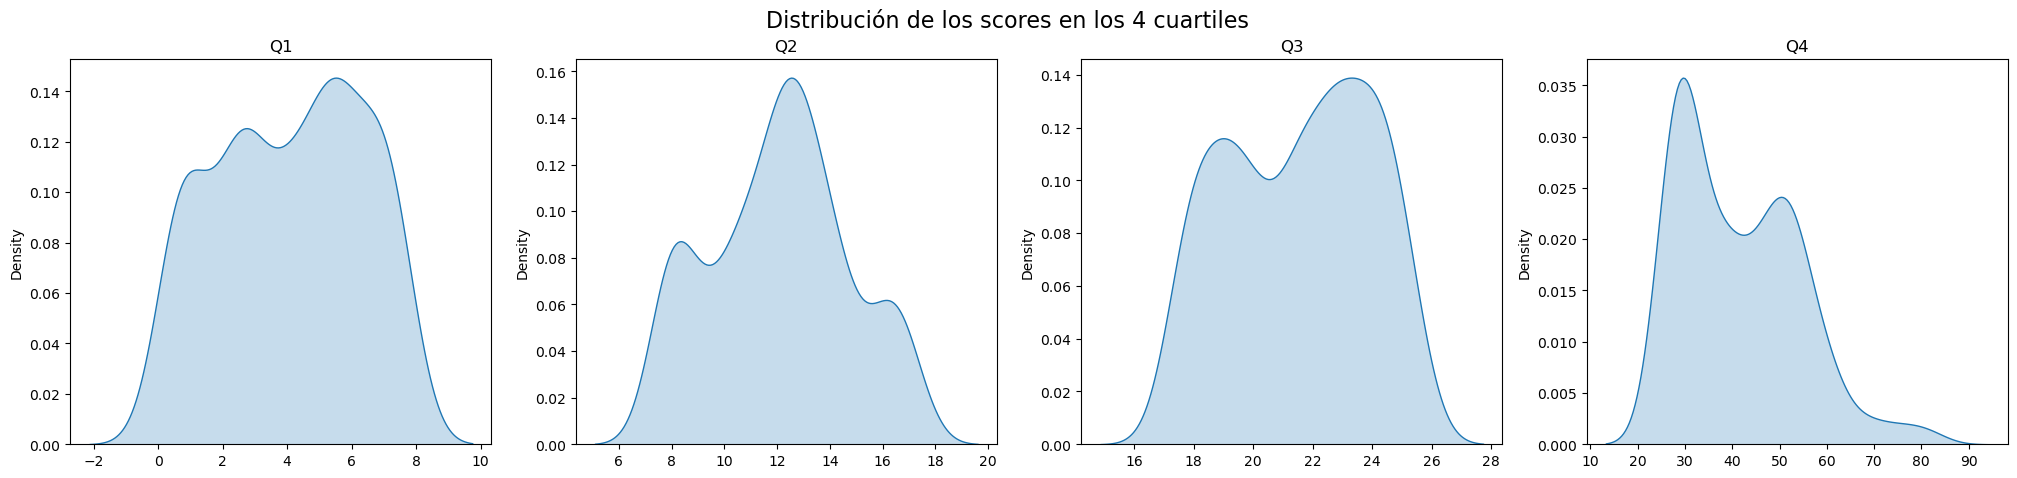

In [34]:
def plot_scores(q_scores):
    fig, axs = plt.subplots(1, 4, figsize=(25,5))

    sns.kdeplot(q_scores[0], ax=axs[0], label="Q1", fill=True)
    sns.kdeplot(q_scores[1], ax=axs[1], label="Q2", fill=True)
    sns.kdeplot(q_scores[2], ax=axs[2], label="Q3", fill=True)
    sns.kdeplot(q_scores[3], ax=axs[3], label="Q4", fill=True)

    axs[0].set_title("Q1")
    axs[1].set_title("Q2")
    axs[2].set_title("Q3")
    axs[3].set_title("Q4")

    plt.suptitle("Distribución de los scores en los 4 cuartiles", fontsize=16)

    plt.show()

plot_scores(q_scores)

Podemos ver cómo el cuartil 4 es el más disperso de todos. Este abarca un rango de scores que va desde el 10 al 90, con un pico entorno a 25. Puede apreciarse, para este último cuartil, un máximo local cerca de 80, que se corresponde con el score obtenido por el mejor individuo de la población final segúm el número de coincidencias que consigue.

A continuación, representamos un gráfico similar, esta vez mostrando las densidades de los valores de penalización y recompensa utilizados por la población de alineadores en la última iteración del algoritmo genético.

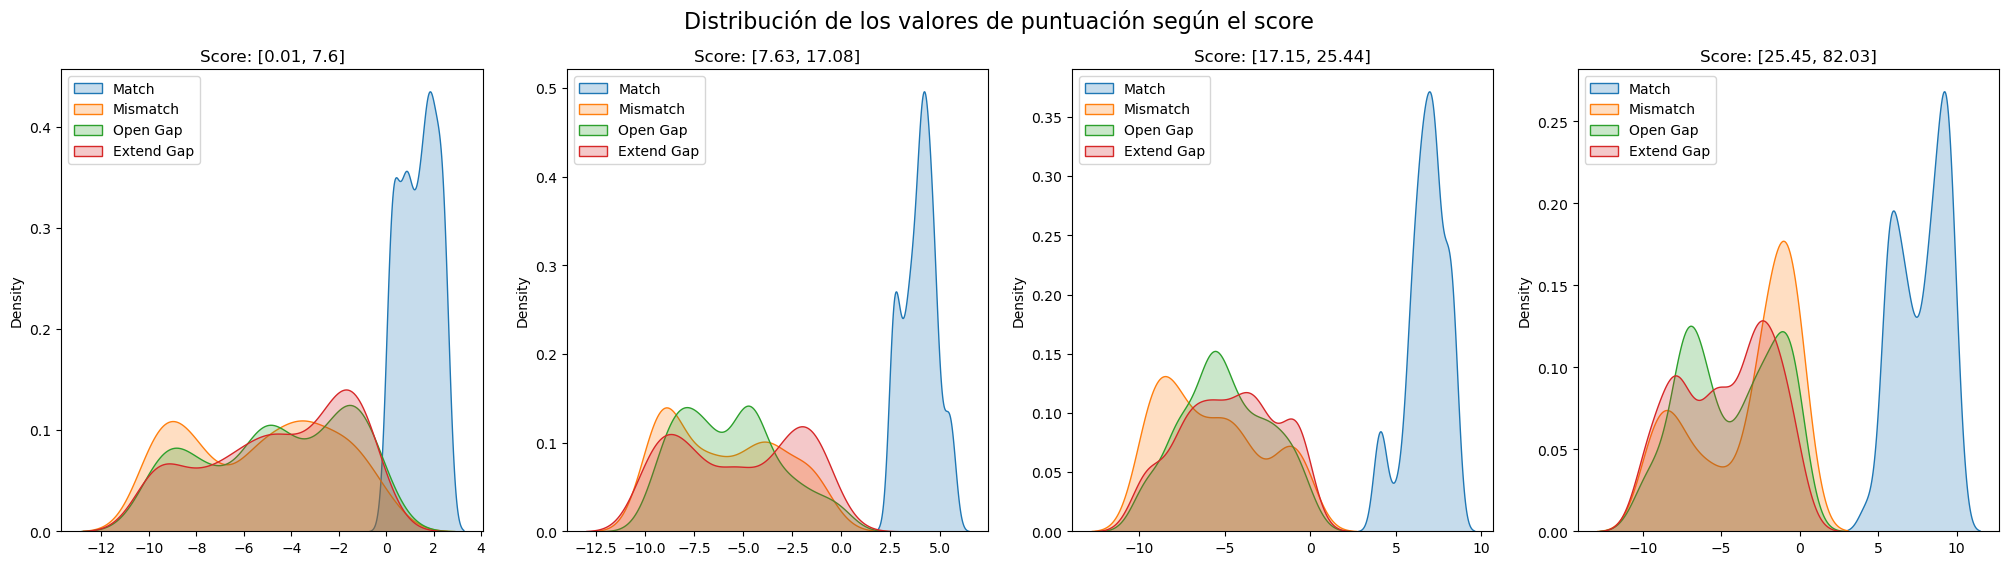

In [35]:
def plot_values(q_scores, q_match_scores, q_mismatch_scores, q_open_gap_scores, q_extend_gap_scores):
    fig, axs = plt.subplots(1, 4, figsize=(25,6))

    sns.kdeplot(q_match_scores[0], ax=axs[0], label="Q1", fill=True)
    sns.kdeplot(q_mismatch_scores[0], ax=axs[0], label="Q1", fill=True)
    sns.kdeplot(q_open_gap_scores[0], ax=axs[0], label="Q1", fill=True)
    sns.kdeplot(q_extend_gap_scores[0], ax=axs[0], label="Q1", fill=True)

    sns.kdeplot(q_match_scores[1], ax=axs[1], label="Q2", fill=True)
    sns.kdeplot(q_mismatch_scores[1], ax=axs[1], label="Q2", fill=True)
    sns.kdeplot(q_open_gap_scores[1], ax=axs[1], label="Q2", fill=True)
    sns.kdeplot(q_extend_gap_scores[1], ax=axs[1], label="Q2", fill=True)

    sns.kdeplot(q_match_scores[2], ax=axs[2], label="Q3", fill=True)
    sns.kdeplot(q_mismatch_scores[2], ax=axs[2], label="Q3", fill=True)
    sns.kdeplot(q_open_gap_scores[2], ax=axs[2], label="Q3", fill=True)
    sns.kdeplot(q_extend_gap_scores[2], ax=axs[2], label="Q3", fill=True)

    sns.kdeplot(q_match_scores[3], ax=axs[3], label="Q4", fill=True)
    sns.kdeplot(q_mismatch_scores[3], ax=axs[3], label="Q4", fill=True)
    sns.kdeplot(q_open_gap_scores[3], ax=axs[3], label="Q4", fill=True)
    sns.kdeplot(q_extend_gap_scores[3], ax=axs[3], label="Q4", fill=True)

    axs[0].set_title(f"Score: [{round(min(q_scores[0]), 2)}, {round(max(q_scores[0]), 2)}]")
    axs[1].set_title(f"Score: [{round(min(q_scores[1]), 2)}, {round(max(q_scores[1]), 2)}]")
    axs[2].set_title(f"Score: [{round(min(q_scores[2]), 2)}, {round(max(q_scores[2]), 2)}]")
    axs[3].set_title(f"Score: [{round(min(q_scores[3]), 2)}, {round(max(q_scores[3]), 2)}]")

    axs[0].legend(["Match", "Mismatch", "Open Gap", "Extend Gap"], loc="upper left")
    axs[1].legend(["Match", "Mismatch", "Open Gap", "Extend Gap"], loc="upper left")
    axs[2].legend(["Match", "Mismatch", "Open Gap", "Extend Gap"], loc="upper left")
    axs[3].legend(["Match", "Mismatch", "Open Gap", "Extend Gap"], loc="upper left")

    plt.suptitle("Distribución de los valores de puntuación según el score", fontsize=16)

    plt.show()

plot_values(q_scores, q_match_scores, q_mismatch_scores, q_open_gap_scores, q_extend_gap_scores)

Como es evidente, los valores de puntuación asociados a `mismatch score`, `open gap` y `extend gap` son todos negativos. Esto es evidente, pued cuando más diferentes sean las secuencias menor score se busca. Los rangos de estos valores son muy similares para todos los cuartiles del score. Sin embargo, esto no pasa para el `match score`. Como podemos ver, a medida que pasamos al siguiente cuartil la distribución de valores de `match score` se desplaza hacia valores más altos. Esto es lógico, ya que el score de un alineamiento debe ser mejor cuantas más coincidencias presente para ambas secuencias. 

En el siguiente gráfico, podemos ver cómo, para mayores valores de score, obtenemos un mayor número de coincidencias, como acabamos de mencionar.

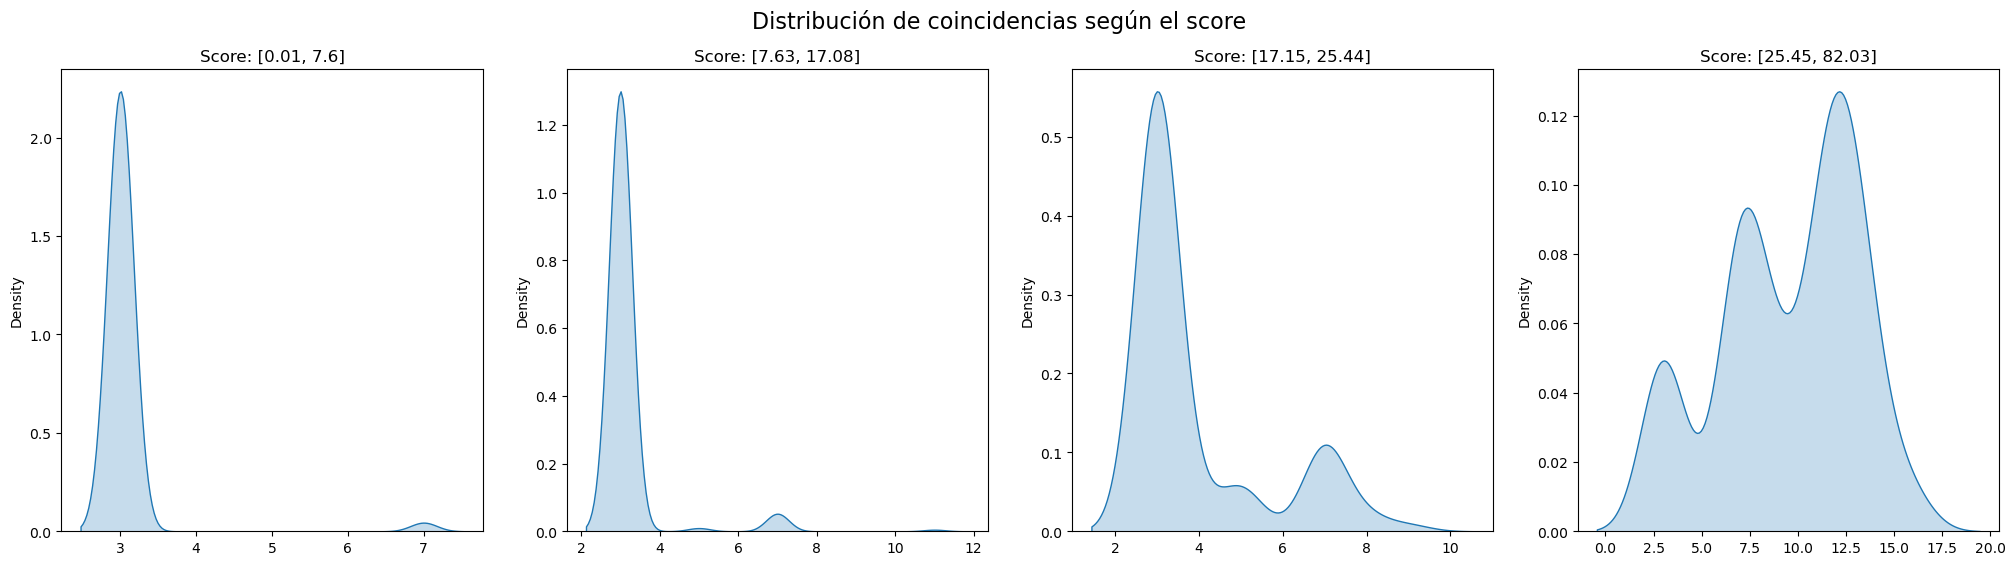

In [36]:
def plot_matches(q_scores, q_matches):
    fig, axs = plt.subplots(1, 4, figsize=(25,6))

    sns.kdeplot(q_matches[0], ax=axs[0], label="Q1", fill=True)
    sns.kdeplot(q_matches[1], ax=axs[1], label="Q2", fill=True)
    sns.kdeplot(q_matches[2], ax=axs[2], label="Q3", fill=True)
    sns.kdeplot(q_matches[3], ax=axs[3], label="Q4", fill=True)
    
    axs[0].set_title(f"Score: [{round(min(q_scores[0]), 2)}, {round(max(q_scores[0]), 2)}]")
    axs[1].set_title(f"Score: [{round(min(q_scores[1]), 2)}, {round(max(q_scores[1]), 2)}]")
    axs[2].set_title(f"Score: [{round(min(q_scores[2]), 2)}, {round(max(q_scores[2]), 2)}]")
    axs[3].set_title(f"Score: [{round(min(q_scores[3]), 2)}, {round(max(q_scores[3]), 2)}]")

    plt.suptitle("Distribución de coincidencias según el score", fontsize=16)

    plt.show()

plot_matches(q_scores, q_matches)

Con esta gráfica podemos ver cómo, a mayor es el score, mayor es el número de coincidencias si la función de fitness viene dada por ello.

### Alineamiento de secuencias con matriz de puntuación

Las matrices de puntuación son una forma de representar las penalizaciones y recompensas de un alineamiento de secuencias. Gracias a ellas, podemos expresar de forma más compacta y general las reglas de alineamiento, utilizando una matriz de puntuación predefinida.

In [37]:
aligner = AlignerBuilder().build()

Haremos uso de las siguientes matrices de puntuación para realizar el alineamiento de las secuencias generadas anteriormente:

In [38]:
def plot_matrix(ax, matrix, title="Matrix"):
    sns.heatmap(matrix, annot=False, ax=ax)
    ax.set_title(title)

    aminos = matrix.alphabet
    ax.set_xticks(ticks=np.arange(len(aminos)) + 0.5, labels=aminos, ha='center', rotation=0)
    ax.set_yticks(ticks=np.arange(len(aminos)) + 0.5, labels=aminos, rotation=0, va='center')

    ax.tick_params(axis='x', bottom=True, labelbottom=True, length=0)
    ax.tick_params(axis='y', length=0)

def plot_from_name(axs, name):
    matrix = substitution_matrices.load(name)
    plot_matrix(axs, matrix, title=name)

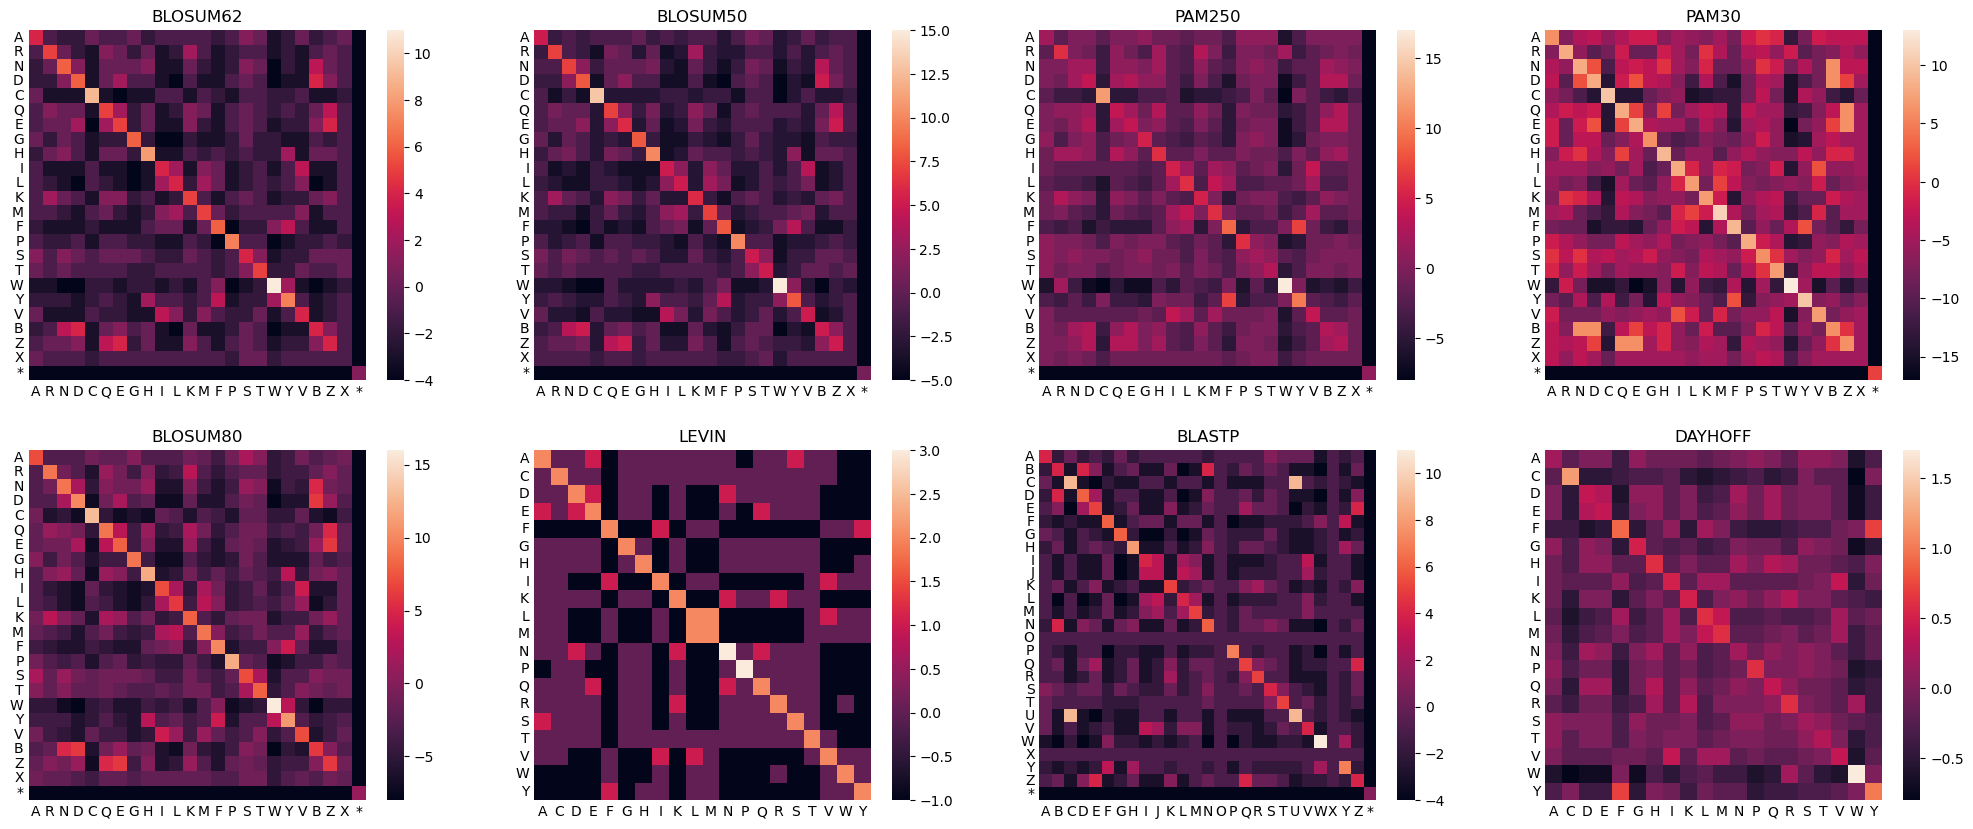

In [39]:
fig, axs = plt.subplots(2, 4, figsize=(25, 10))

plot_from_name(axs[0][0], "BLOSUM62")
plot_from_name(axs[0][1], "BLOSUM50")
plot_from_name(axs[0][2], "PAM250")
plot_from_name(axs[0][3], "PAM30")
plot_from_name(axs[1][0], "BLOSUM80")
plot_from_name(axs[1][1], "LEVIN")
plot_from_name(axs[1][2], "BLASTP")
plot_from_name(axs[1][3], "DAYHOFF")

plt.show()

Las matrices nos dicen cuánto se penaliza o se recompensa en el alineamiento cada vez que se produce una coincidencia o sustitución de aminoácidos. Esto es realmente útil, pues debido a las propiedades bioquímicas de los mismos, puede tener más o menos sentido que en la naturaleza se de o no una sustitución.

Los resultados obtenidos con cada una de las matrices los guardaremos en el siguiente dataframe:

In [40]:
results = {"Matrix": [], "Score": [], "Matches": []}

In [41]:
def add_result(alignment, name):
    global results
    results["Matrix"].append(name)
    results["Score"].append(alignment.score)
    results["Matches"].append(get_matches(alignment))

- Para la matriz de puntuación BLOSUM62

La matriz de puntuación BLOSUM62 es una de las matrices de sustitución de aminoácidos más utilizadas en bioinformática. Su nombre significa "BLOcks SUbstitution Matrix" y el número 62 indica el porcentaje de identidad de secuencia en los bloques de alineamientos que se utilizaron para construir la matriz. BLOSUM62 se basa en bloques de secuencias de proteínas altamente conservadas, en los que las secuencias tienen un 62% o menos de identidad. Este nivel de conservación hace que sea ideal para identificar similitudes entre secuencias moderadamente relacionadas.

Los puntajes en la matriz BLOSUM62 representan la probabilidad de que un aminoácido se sustituya por otro a lo largo de la evolución. Puntajes positivos indican que la sustitución es más probable que al azar, lo que significa que los aminoácidos tienen propiedades bioquímicas similares, como el tamaño, la carga, o la hidrofobicidad. Puntajes negativos indican que la sustitución es menos probable, y por lo tanto es menos probable encontrar tales cambios en secuencias relacionadas. Esta matriz se usa comúnmente para detectar relaciones evolutivas en proteínas con divergencia moderada.

In [42]:
alignments = aligner.align(sequence1, sequence2, matrix="blosum62")

In [43]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)

    add_result(alignment, "BLOSUM62")
    break

Matches: 14
Score: 109.0
Alignment:
target            1 YHMYE--VMPSWYMPCDAESEI-GMVYMTKAH-FP-------YQ--S--P-------DNP
                  0 |-.-.--.---|---|-------||---|-.|-|--------|.--.--|-------|--
query             0 Y-V-QGTI---W---C------WGM---T-SHYF-LGSVLHHYECWNLAPARQFISFD--

target           39 -GGWN--FALW 47
                 60 -|--|--|-.. 71
query            39 EG--NINF-MY 47



- Para la matriz de puntuación BLOSUM50

La matriz BLOSUM50, al igual que BLOSUM62, se construye a partir de alineamientos de secuencias de proteínas conservadas. Sin embargo, BLOSUM50 utiliza bloques con un 50% o menos de identidad, lo cual significa que se basa en secuencias más divergentes. En consecuencia, BLOSUM50 es más adecuada para detectar similitudes entre secuencias de proteínas que han divergido más tiempo atrás, es decir, aquellas que están más distantes evolutivamente. Esta matriz es más sensible a relaciones evolutivas profundas, siendo menos estricta que BLOSUM62 y permitiendo encontrar similitudes que podrían pasar desapercibidas con matrices más conservadoras.

In [44]:
alignments = aligner.align(sequence1, sequence2, matrix="blosum50")

In [45]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)

    add_result(alignment, "BLOSUM50")
    break

Matches: 15
Score: 143.0
Alignment:
target            1 YHMYEVMP--S-WYMPCDAESEI-GMV---Y-M-TKA--H-F------PY--Q--SP-DN
                  0 |----|----.-|---|-------||----|-.-.----|-.------|---|--|--|-
query             0 Y----V--QGTIW---C------WGM-TSHYFLGS--VLHHYECWNLAP-ARQFIS-FD-

target           38 P-GGWN--FALW 47
                 60 --|--|--|-.. 72
query            39 -EG--NINF-MY 47



- Para la matriz de puntuación PAM250

La matriz PAM250 (Point Accepted Mutation 250) es una matriz de sustitución de aminoácidos que se basa en el modelo de mutaciones aceptadas. "PAM" se refiere a mutaciones aceptadas por 100 residuos de aminoácidos, y el número 250 significa que la matriz modela 250 mutaciones por cada 100 residuos en promedio. Esto implica una gran distancia evolutiva, lo cual hace que PAM250 sea adecuada para identificar relaciones entre secuencias muy divergentes, es decir, secuencias que han evolucionado durante un largo periodo.

PAM250 asigna puntajes positivos a aquellas sustituciones que se han conservado a pesar de la divergencia evolutiva, lo cual significa que los cambios no han afectado la función de la proteína. Sin embargo, también penaliza las sustituciones que son menos probables debido a diferencias significativas en las propiedades de los aminoácidos. Es útil para analizar secuencias con alta divergencia y detectar relaciones entre secuencias que se han diferenciado significativamente.

In [46]:
alignments = aligner.align(sequence1, sequence2, matrix="pam250")

In [47]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)

    add_result(alignment, "PAM250")
    break

Matches: 11
Score: 132.0
Alignment:
target            1 YHMYE--VMPSWYMPCDAESEI-GMVYMTKAHFPYQSPDNP-GGW--N-FALW-CW-L 50
                  0 |-.-.--.---|---|-------||---|-.|.-.-------|.---.-.----||-| 58
query             0 Y-V-QGTI---W---C------WGM---T-SHY-F------LGS-VLHHY---ECWNL 29



- Para la matriz de puntuación pam30

La matriz PAM30 también pertenece a la familia de matrices PAM, pero representa un modelo de sustitución que considera solo 30 mutaciones aceptadas por cada 100 residuos. Esto significa que es más adecuada para secuencias que han divergido recientemente, es decir, secuencias cercanas en términos evolutivos. PAM30 es más estricta que PAM250, asignando puntajes más altos a coincidencias exactas y penalizando fuertemente las sustituciones no conservadoras y los gaps. Por esta razón, PAM30 es ideal para comparar secuencias que son muy similares o altamente conservadas.

In [48]:
alignments = aligner.align(sequence1, sequence2, matrix="pam30")

In [49]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)

    add_result(alignment, "PAM30")
    break

Matches: 16
Score: 140.0
Alignment:
target            1 YHMYEVMPS----WYMPCDAESEI-GMVYMTKA-H-FP-------Y---------Q--SP
                  0 |----|-------|---|-------||---|---|-|--------|---------|--|-
query             0 Y----V---QGTIW---C------WGM---T--SHYF-LGSVLHHYECWNLAPARQFIS-

target           36 -D--NPGGW-NFAL 46
                 60 -|--|-----||-. 74
query            37 FDEGN----INF-M 46



- Para la matriz de puntuación BLOSUM80

La matriz BLOSUM80 se construye a partir de bloques de secuencias de proteínas que tienen un 80% o menos de identidad. Esto significa que BLOSUM80 es más estricta que BLOSUM62 y está mejor adaptada para detectar similitudes entre secuencias altamente conservadas. Al asignar puntajes más altos a las sustituciones entre aminoácidos muy similares, BLOSUM80 permite identificar relaciones evolutivas entre secuencias que están más cercanas evolutivamente. Es especialmente útil cuando se necesita una alta especificidad, ya que penaliza fuertemente las sustituciones que no son conservadoras.

In [50]:
alignments = aligner.align(sequence1, sequence2, matrix="blosum80")

In [51]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)

    add_result(alignment, "BLOSUM80")
    break

Matches: 15
Score: 171.0
Alignment:
target            1 YHMYEVMP--S-WYMPCDAESEI-GMVYMTKAH-FP-------YQ----SP-------DN
                  0 |----|----.-|---|-------||---|-.|-|--------|.----.|-------|-
query             0 Y----V--QGTIW---C------WGM---T-SHYF-LGSVLHHYECWNLAPARQFISFD-

target           38 P-GGWN--FALW 47
                 60 --|--|--|-.. 72
query            39 -EG--NINF-MY 47



- Para la matriz LEVIN

La matriz LEVIN es una matriz de sustitución que se basa en un modelo evolutivo de Markov, el cual describe la probabilidad de que un aminoácido sea reemplazado por otro a lo largo del tiempo. Esta matriz tiene en cuenta las propiedades bioquímicas y estructurales de los aminoácidos, lo cual la hace útil para modelar sustituciones que sean químicamente razonables y funcionalmente aceptables. Al considerar estas propiedades, la matriz LEVIN busca reflejar mejor la realidad de las mutaciones que ocurren en las secuencias de proteínas y cómo estas son seleccionadas evolutivamente.

In [52]:
alignments = aligner.align(sequence1, sequence2, matrix="levin")

In [53]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)

    add_result(alignment, "LEVIN")
    break

Matches: 15
Score: 42.0
Alignment:
target            1 YHMYEV--------MP-SW-Y-MPCDAE-SEIGMV--Y----MTKAHFPY--Q--SP-D-
                  0 |----|--------|--|--|-.------|-.-.---|----.--|--|---|--|--|-
query             0 Y----VQGTIWCWGM-TS-HYFL-----GS-V-L-HHYECWNL--A--P-ARQFIS-FDE

target           37 -NPGGW-NFAL 46
                 60 -|-----||-. 71
query            40 GN----INF-M 46



- Para la matriz BLASTP

La matriz de puntuación BLASTP es una matriz de sustitución de aminoácidos que se utiliza en el algoritmo BLAST (Basic Local Alignment Search Tool) para alinear secuencias de proteínas y buscar similitudes entre ellas. Esta matriz se basa en la idea de que las sustituciones de aminoácidos en secuencias de proteínas pueden ser modeladas por un modelo de evolución de Markov, que describe la probabilidad de que un aminoácido sea reemplazado por otro a lo largo del tiempo evolutivo. La matriz BLASTP se construye a partir de un modelo de evolución de Markov que considera las propiedades bioquímicas y estructurales de los aminoácidos, así como la frecuencia de sustituciones observadas en secuencias de proteínas.

In [54]:
alignments = aligner.align(sequence1, sequence2, matrix="blastp")

In [55]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)

    add_result(alignment, "BLASTP")
    break

Matches: 14
Score: 109.0
Alignment:
target            1 YHMYE--VMPSWYMPCDAESEI-GMVYMTKAH-FP-------YQ--S--P-------DNP
                  0 |-.-.--.---|---|-------||---|-.|-|--------|.--.--|-------|--
query             0 Y-V-QGTI---W---C------WGM---T-SHYF-LGSVLHHYECWNLAPARQFISFD--

target           39 -GGWN--FALW 47
                 60 -|--|--|-.. 71
query            39 EG--NINF-MY 47



- Para la matriz DAYHOFF

La matriz DAYHOFF es una de las matrices de sustitución más antiguas y también se basa en un modelo de evolución de Markov. Fue creada por Margaret Dayhoff a partir de datos sobre las tasas de sustitución entre pares de aminoácidos en familias de proteínas conservadas. Al igual que otras matrices de este tipo, DAYHOFF considera las propiedades bioquímicas de los aminoácidos y la frecuencia de sustituciones para asignar un puntaje a cada posible cambio entre ellos. Esta matriz ha sido muy influyente en el desarrollo de matrices posteriores y se usa para identificar similitudes evolutivas entre secuencias de proteínas.

In [56]:
alignments = aligner.align(sequence1, sequence2, matrix="dayhoff")

In [57]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)

    add_result(alignment, "DAYHOFF")
    break

Matches: 11
Score: 13.199999999999996
Alignment:
target            1 YHMYE--VMPSWYMPCDAESEI-GMVYMTKAHFPYQSPDNP-GGW--N-FALW-CW-L 50
                  0 |-.-.--.---|---|-------||---|-.|.-.-------|.---.-.----||-| 58
query             0 Y-V-QGTI---W---C------WGM---T-SHY-F------LGS-VLHHY---ECWNL 29



- Para una matriz personalizada

Uno podría definir una matriz de puntuación personalizada para adaptarse a un problema específico o a un conjunto de datos particular. Por ejemplo, si se tiene información previa sobre las propiedades de los aminoácidos o las relaciones entre ellos, se podría diseñar una matriz de puntuación que refleje esas características específicas. Esto permitiría ajustar el alineamiento de las secuencias para que refleje mejor las similitudes y diferencias relevantes en el contexto del problema en cuestión.

A continuación, cogeremos una matriz ya diseñada, la BLOSUM50, y alinearemos las dos secuencias generadas anteriormente.

In [58]:
blosum50 = substitution_matrices.load("BLOSUM50")

Si visualizamos la matriz original, 

In [59]:
blosum50[('A', 'R')] = -1
blosum50[('R', 'A')] = -1
blosum50[('A', 'A')] = 5
blosum50[('R', 'R')] = 5
blosum50[('A', 'M')] = -4
blosum50[('M', 'A')] = -3

In [60]:
alignments = aligner.align(sequence1, sequence2, matrix=blosum50)

In [61]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)
    break

Matches: 11
Score: 13.199999999999996
Alignment:
target            1 YHMYE--VMPSWYMPCDAESEI-GMVYMTKAHFPYQSPDNP-GGW--N-FALW-CW-L 50
                  0 |-.-.--.---|---|-------||---|-.|.-.-------|.---.-.----||-| 58
query             0 Y-V-QGTI---W---C------WGM---T-SHY-F------LGS-VLHHY---ECWNL 29



Por último, cargamos una matriz personalizada directamente desde un archivo, y alineamos las dos secuencias generadas anteriormente.

In [62]:
matrix = substitution_matrices.read("./data/MATRIX")

Esta matriz se corresponde con la matrix DAYHOFF, auqnue se han modificados todos los elementos de la diagonal inversa para que su puntuación sea muy cercana a 1. Si lo visualizamos,

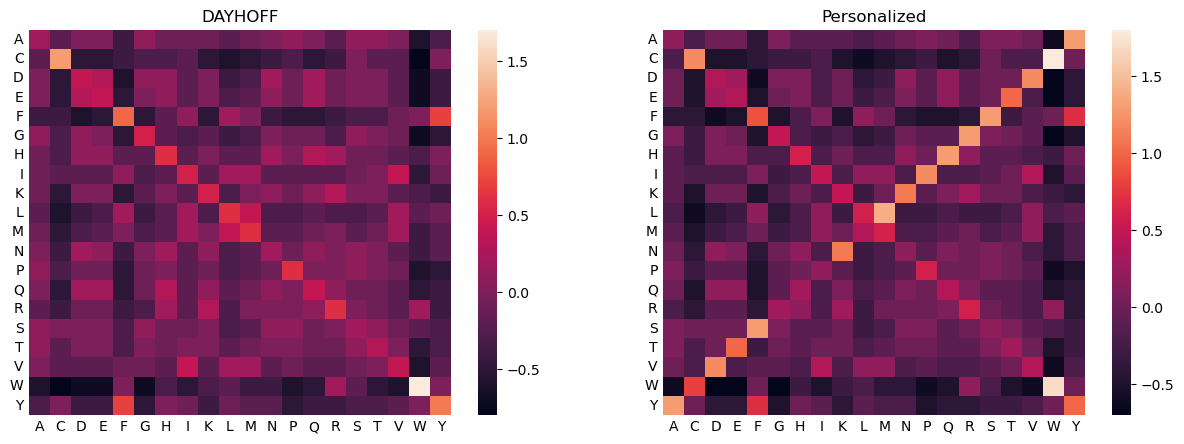

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

plot_from_name(axs[0], "DAYHOFF")
plot_matrix(axs[1], matrix, title="Personalized")

plt.show()

Si alineamos, obtenemos lo siguiente:

In [64]:
alignments = aligner.align(sequence1, sequence2, matrix=matrix)

In [65]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)

    add_result(alignment, "Personalized")
    break

Matches: 11
Score: 13.199999999999996
Alignment:
target            1 YHMYE--VMPSWYMPCDAESEI-GMVYMTKAHFPYQSPDNP-GGW--N-FALW-CW-L 50
                  0 |-.-.--.---|---|-------||---|-.|.-.-------|.---.-.----||-| 58
query             0 Y-V-QGTI---W---C------WGM---T-SHY-F------LGS-VLHHY---ECWNL 29



Obtenemos el mismo número de matches, pero un score menor.

#### Resultados

Se han obtenido los siguientes resultados para las distintas matrices de puntuación utilizadas:

In [66]:
import pandas as pd

In [67]:
results = pd.DataFrame(results)
results.sort_values(by="Matches", ascending=False, inplace=True)
results

,Matrix,Score,Matches
3,PAM30,140.0,16
1,BLOSUM50,143.0,15
4,BLOSUM80,171.0,15
5,LEVIN,42.0,15
0,BLOSUM62,109.0,14
6,BLASTP,109.0,14
2,PAM250,132.0,11
7,DAYHOFF,13.2,11
8,Personalized,13.2,11


Podemos ver como la matriz PAM30, la cual es útil para numerosos estudios de procesos evolutivos, es la que mayor número de coincidencias ha obtenido, con un total de 14, junto con la matriz BLOSUM80. Las peores han sido las matrices PAM250 y DAYHOFF, con un total de 10 coincidencias y un score de 12.4

## Descarga de ficheros FASTA

A continuación, se descargan secuencias de aminoacidos correspondientes a distintas proteínas de la base de datos de NCBI. Para ello, haremos uso de un `DataLoader`, del que ya se disponía de una versión previamente implementada en la práctica anterior.

In [68]:
sequenceLoader = DataLoaderFactory.get_loader("api")

In [69]:
sequence1 = sequenceLoader.load(('ABG47031.1',))[0].seq
sequence2 = sequenceLoader.load(('AUJ50941.1',))[0].seq

print(f"Sequence 1: {sequence1}")
print(f"Sequence 2: {sequence2}")

File ABG47031_1.fasta created
File AUJ50941_1.fasta created
Sequence 1: MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFR
Sequence 2: MKYNEINNEGVEKLMDIFYAKIRTHEQLGPIFNGAVGIDDASWERHKEKIAKFWKTMLLNENLYMGNPVQPHINLLPFDIKLFDVWLDLFKECLDQVFEEKASEHFYEVACNIAKNFKAVLFQQ


### Alineamiento de secuencias con algoritmo genético

In [70]:
geneticAlgorithm = GeneticAlgorithm(1400, 20, sequence1, sequence2, fitness_function)
aligners, best_aligner = geneticAlgorithm.run()

In [71]:
print(best_aligner.args())

AlignerArgs(match_score=7.566417478640156, 
                    mismatch_score=-6.819611401004826, 
                    target_internal_open_gap_score=-2.3912329943708563, 
                    target_internal_extend_gap_score=-9.510972200806204, 
                    target_left_open_gap_score=-5.0673978556835415, 
                    target_left_extend_gap_score=-2.560199087080093, 
                    target_right_open_gap_score=-0.19138301937818514, 
                    target_right_extend_gap_score=-2.5729244322843847, 
                    query_internal_open_gap_score=-0.4217889717967582, 
                    query_internal_extend_gap_score=-0.2597892544972402, 
                    query_left_open_gap_score=-4.411910138335298, 
                    query_left_extend_gap_score=-7.2764695660137955, 
                    query_right_open_gap_score=-0.13018483893227684, 
                    query_right_extend_gap_score=-5.486511808255247)


In [72]:
alignment = best_aligner.align(sequence1, sequence2)

for alignment in alignment:
    print(f"Alignment: {alignment[0]}")
    print(f"Alignment: {alignment[1]}")
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    break

Alignment: H-LTPEEK-SA-VTAL-WGK-VNVDEVGGEALGR-LLVVYPWTQRFF-ESFGD-LSTPDAV-MGNPKV-KA-H-GKKV-L-GA-FSD-G-L-A-H-LDNL-KGTFATLSE-LHCD-KLHVDPENF
Alignment: HK----EKI-AK----FW-KT-------------MLL----------NE----NL------YMGNP-VQ--PHI----NLL--PF-DI-KLF-DVWLD-LFK-------ECL--DQ---V----F
Matches: 29
Score: 135.66331593923854


Veamos ahora, al igual que hicimos antes, cómo son los elementos de la población en la última iteración del algoritmo genético.

In [73]:
match_scores = []
matches = []
mismatch_scores = []
open_gap_scores = []
extend_gap_scores = []
scores = []

for aligner in aligners:
    alignment = aligner.align(sequence1, sequence2)[0]

    match_scores.append(aligner.args().match_score)
    mismatch_scores.append(aligner.args().mismatch_score)
    open_gap_scores.append(aligner.args().target_internal_open_gap_score)
    extend_gap_scores.append(aligner.args().target_internal_extend_gap_score)

    scores.append(alignment.score)
    matches.append(get_matches(alignment))

In [74]:
scores = np.array(scores)
match_scores = np.array(match_scores)
mismatch_scores = np.array(mismatch_scores)
open_gap_scores = np.array(open_gap_scores)
extend_gap_scores = np.array(extend_gap_scores)
matches = np.array(matches)

quartiles = np.percentile(scores, [25, 50, 75])

print(f"Los scores se pueden dividir en los siguientes 4 cuartiles:")
print(f"Q1: {quartiles[0]} - Q2: {quartiles[1]} - Q3: {quartiles[2]}")

Los scores se pueden dividir en los siguientes 4 cuartiles:
Q1: 11.07446482110603 - Q2: 22.15884526943574 - Q3: 39.0484448142317


In [75]:
q_scores, q_matches, q_match_scores, q_mismatch_scores, q_open_gap_scores, q_extend_gap_scores = get_quartiles()

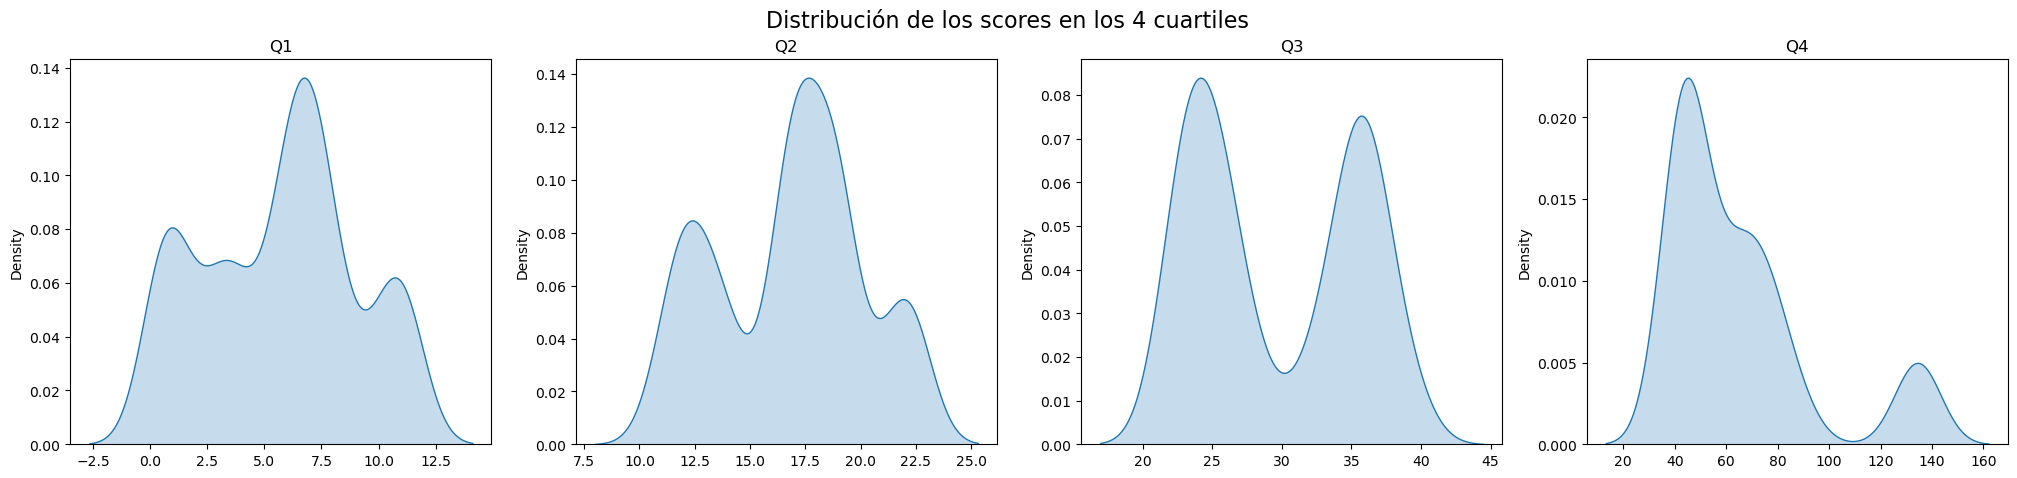

In [76]:
plot_scores(q_scores)

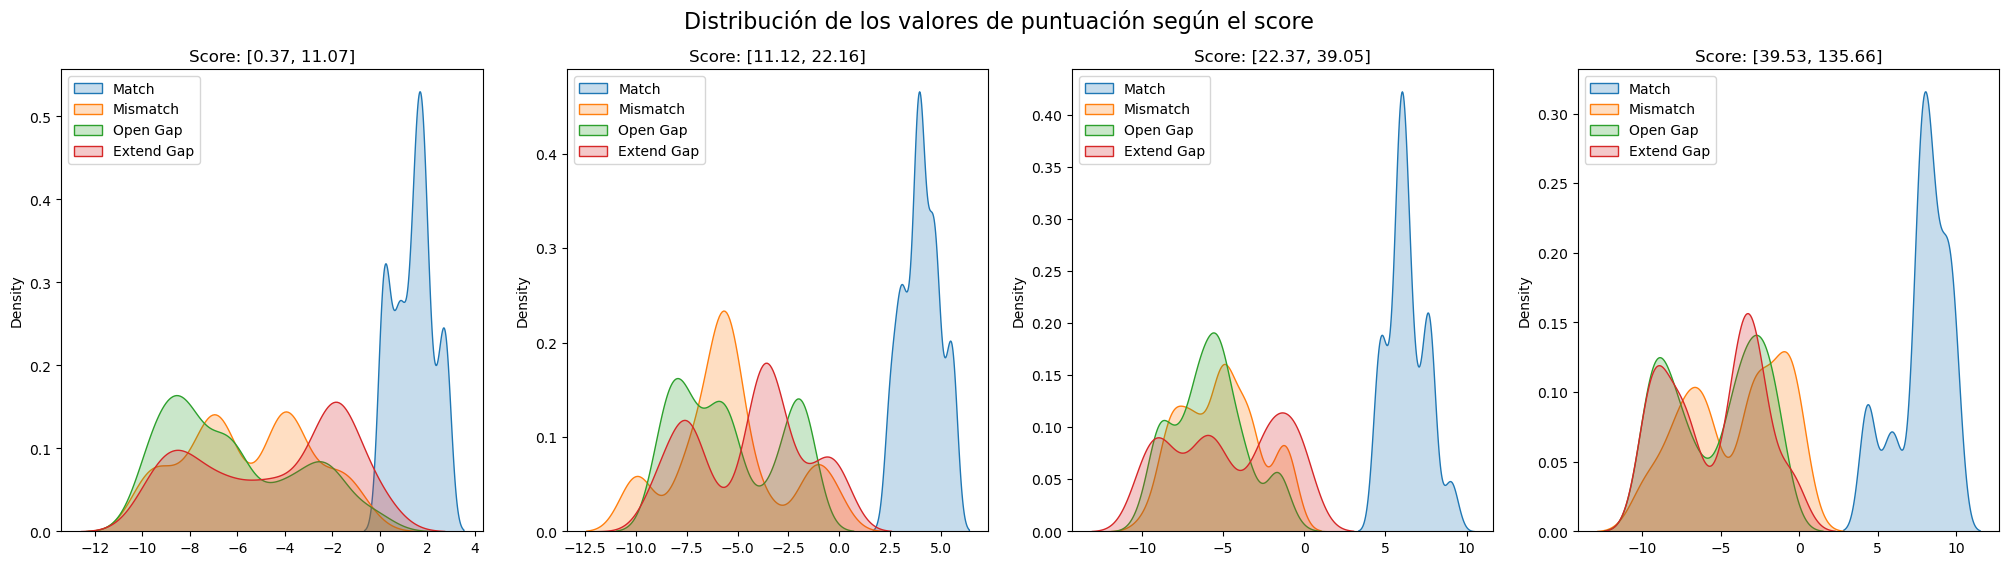

In [77]:
plot_values(q_scores, q_match_scores, q_mismatch_scores, q_open_gap_scores, q_extend_gap_scores)

Como es evitende, al ser la función de fitness el número de coincidencias, el `match_score` suele tomarse positivo, mientras que el resto de valores suelen ser negativos. Podemos ver como, a mayor score, mayor es el `match_score` asociado al alineador, mientras que las penalizaciónes suelen mantenerse en el mismo rango.

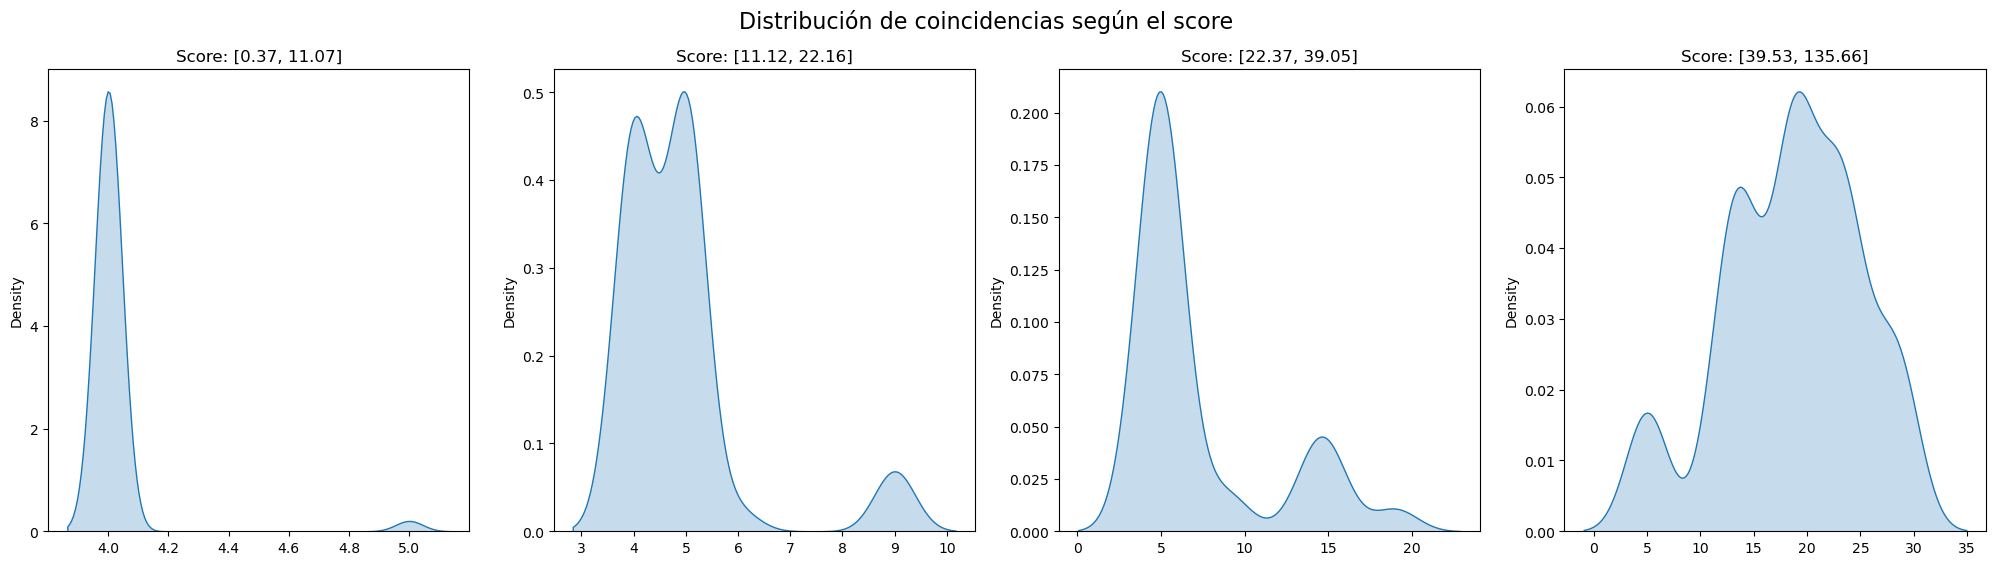

In [78]:
plot_matches(q_scores, q_matches)

### Alineamiento de secuencias con matriz de puntuación

In [79]:
aligner = AlignerBuilder().build()

Para este apartado, volveremos a utilizar las matrices de puntuación BLOSUM62, BLOSUM50, PAM250, PAM30, BLOSUM80, LEVIN, BLASTP, DAYHOFF y una matriz personalizada.

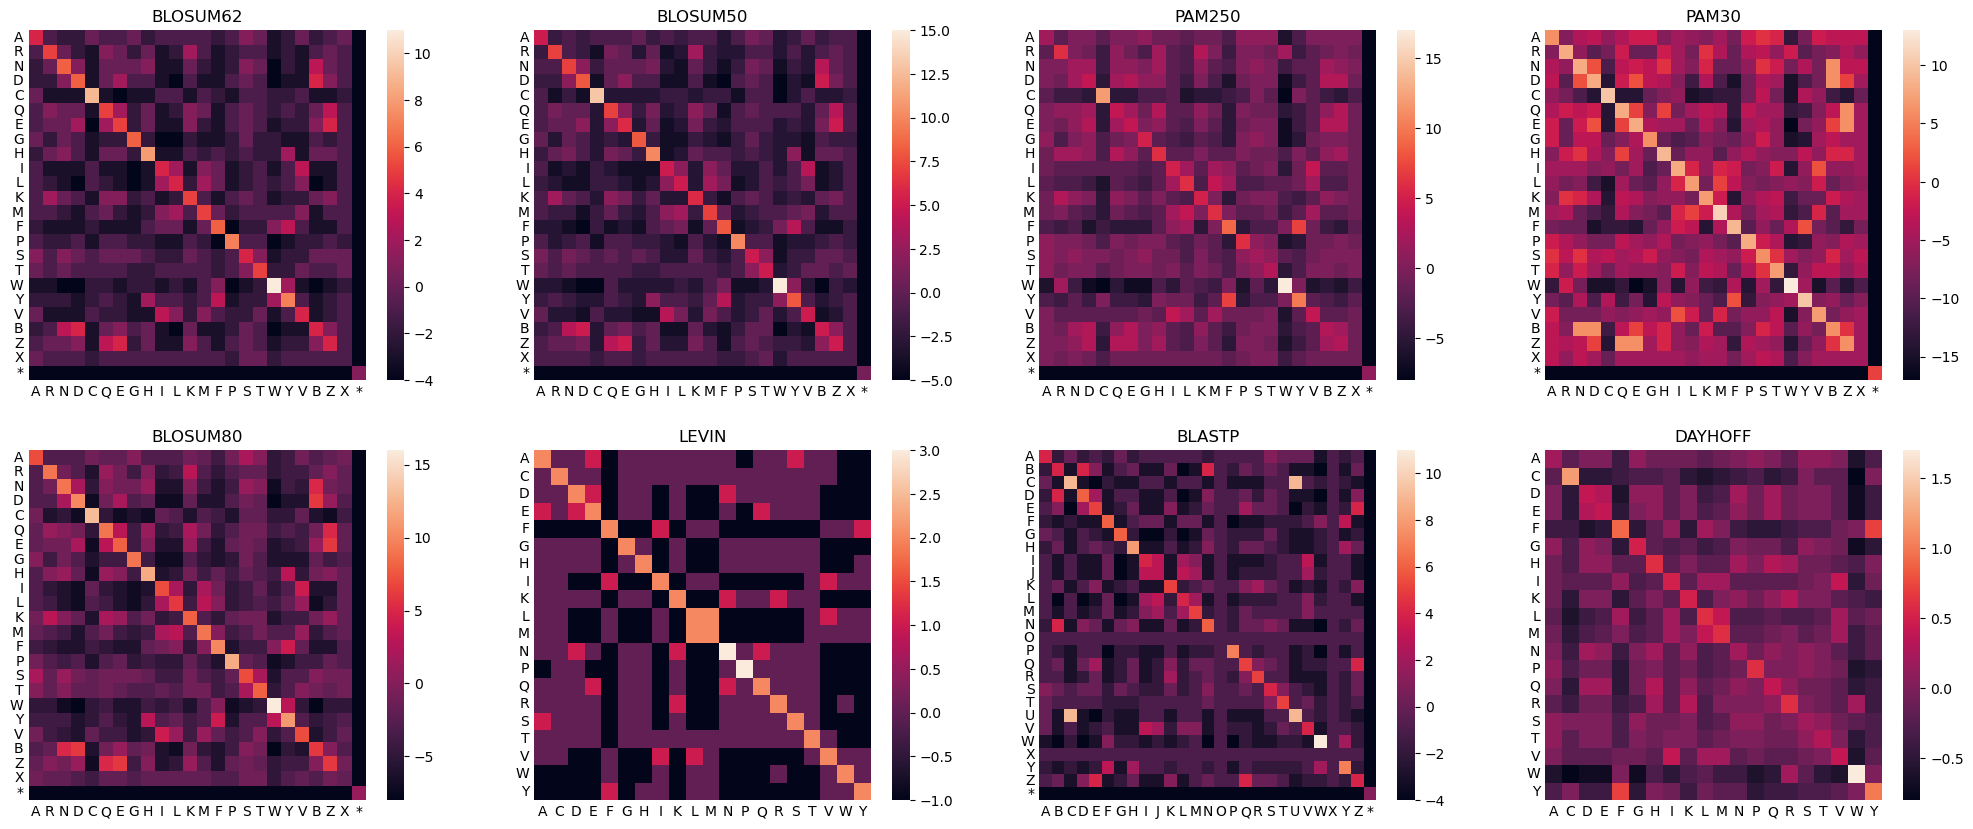

In [80]:
fig, axs = plt.subplots(2, 4, figsize=(25, 10))

plot_from_name(axs[0][0], "BLOSUM62")
plot_from_name(axs[0][1], "BLOSUM50")
plot_from_name(axs[0][2], "PAM250")
plot_from_name(axs[0][3], "PAM30")
plot_from_name(axs[1][0], "BLOSUM80")
plot_from_name(axs[1][1], "LEVIN")
plot_from_name(axs[1][2], "BLASTP")
plot_from_name(axs[1][3], "DAYHOFF")

plt.show()

#### Caso 1: Hemoglobina humana y hemoglobina bacteriana

Probaremos a usar las matrices de alineamiento con las secuencias de aminoácidos ya cargadas y, posteriormente, probaremos con otras proteínas. Los resultados serán guardados en el siguiente dataframe:

In [81]:
results = {"Matrix": [], "Score": [], "Matches": []}

- Para la matriz de puntuación BLOSUM62

In [82]:
alignments = aligner.align(sequence1, sequence2, matrix="blosum62")

In [83]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)

    add_result(alignment, "BLOSUM62")
    break

Matches: 40
Score: 248.0
Alignment:
target            0 MV-H--LTP--E--EKS------A-V-TA---LWGK-V-NVDEVGGEALGRLLVVYP---
                  0 |--.--.----|--||-------|-.-|----|-|--.-|----|--|.|---.------
query             0 M-KYNEI--NNEGVEK-LMDIFYAKIRT-HEQL-G-PIFN----G--AVG---I---DDA

target           37 -WTQRFF--E--S-FGDLS--TP----DA-V-MGNPKVKA-HGKKV-LGA--FSDG--LA
                 60 -|-.|----|--.-|------|-----.--.-||||-|.--|---.-|----|-|---|-
query            41 SW-ER--HKEKIAKF----WKT-MLLNE-NLYMGNP-VQ-PH---INL--LPF-D-IKL-

target           77 H----LDNL-KGT------F---ATLSELH-----CD--KLHVDPENFR 105
                120 -----||-|-|--------|---|--||-|-----|.--|------||. 169
query            82 -FDVWLD-LFK--ECLDQVFEEKA--SE-HFYEVACNIAK------NFK 118



- Para la matriz de puntuación BLOSUM50

In [84]:
alignments = aligner.align(sequence1, sequence2, matrix="blosum50")

In [85]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)

    add_result(alignment, "BLOSUM50")
    break

Matches: 40
Score: 318.0
Alignment:
target            0 M----VHLTP-E--EKS------A-V-TA---LWGK-V-NVDEVGGEALGRLLVVYP---
                  0 |----..----|--||-------|-.-|----|-|--.-|----|--|.|---.------
query             0 MKYNEIN---NEGVEK-LMDIFYAKIRT-HEQL-G-PIFN----G--AVG---I---DDA

target           37 -WTQRFF--E--S-FGD----L-STPDA-V-MGNPKVKA-HGKKV-LGA--FSDG--LAH
                 60 -|-.|----|--.-|------|-.--.--.-||||-|.--|---.-|----|-|---|--
query            41 SW-ER--HKEKIAKF--WKTMLLN--E-NLYMGNP-VQ-PH---INL--LPF-D-IKL--

target           78 ----LDNL-KGT------F---ATLSELH-----CD--KLHVDPENFR 105
                120 ----||-|-|--------|---|--||-|-----|.--|------||. 168
query            82 FDVWLD-LFK--ECLDQVFEEKA--SE-HFYEVACNIAK------NFK 118



- Para la matriz de puntuación PAM250

In [86]:
alignments = aligner.align(sequence1, sequence2, matrix="pam250")

In [87]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)

    add_result(alignment, "PAM250")
    break

Matches: 38
Score: 267.0
Alignment:
target            0 M----VHLTP-E--EKSAVTALW-G----KV--NVDEVG----GEALGRLLVVY--P-WT
                  0 |----..----|--||-----|--.----|.--.-...|----|-|.|---.----.-|-
query             0 MKYNEIN---NEGVEK-----L-MDIFYAKIRTH-EQLGPIFNG-AVG---I--DDASW-

target           39 QRFF--E--S-FGD----L-STPDA-V-MGNPKVKAHGKKV-LG-AFSDG--LA-H--LD
                 60 .|----|--.-|------|-.--.--.-||||-|..|---.-|--.|-|---|--.--||
query            43 ER--HKEKIAKF--WKTMLLN--E-NLYMGNP-VQPH---INL-LPF-D-IKL-FDVWLD

target           80 NL-K---GT--F---ATLSELH-----CD--KLH---VDPEN-FR 105
                120 -|-|---.---|---|--||-|-----|.--|-.---|-----|. 165
query            88 -LFKECLD-QVFEEKA--SE-HFYEVACNIAK-NFKAV----LFQ 123



- Para la matriz de puntuación pam30

In [88]:
alignments = aligner.align(sequence1, sequence2, matrix="pam30")

In [89]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)

    add_result(alignment, "PAM30")
    break

Matches: 41
Score: 335.0
Alignment:
target            0 M----VHLTP--E--EKS------A-V-TA---LWGK-V-N--V--D----EVGG---E-
                  0 |----.------|--||-------|-.-|----|-|--.-|--|--|----|------|-
query             0 MKYNEI----NNEGVEK-LMDIFYAKIRT-HEQL-G-PIFNGAVGIDDASWE---RHKEK

target           27 -ALGRLLVV-YPW-TQRFF----ESFGDLSTPDAV-MGNPKVKA--HGKKV-LGA--FSD
                 60 -|--------.-|-|--------|---.|-------||||-|----|---.-|----|-|
query            49 IA-------KF-WKT----MLLNE---NL------YMGNP-V--QPH---INL--LPF-D

target           74 G--LAH----LDNL-KGT------F---ATLSELH-----CD--KLHVDPENF 104
                120 ---|------||-|-|--------|---|--||-|-----|.--|------|| 173
query            79 -IKL--FDVWLD-LFK--ECLDQVFEEKA--SE-HFYEVACNIAK------NF 117



- Para la matriz de puntuación BLOSUM80

In [90]:
alignments = aligner.align(sequence1, sequence2, matrix="blosum80")

In [91]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)

    add_result(alignment, "BLOSUM80")
    break

Matches: 40
Score: 389.0
Alignment:
target            0 MV-H--LTP--E--EKS------A-V-TA---LWGK-V-NVDEVGGEALGRLLVVYP---
                  0 |--.--.----|--||-------|-.-|----|-|--.-|----|--|.|---.------
query             0 M-KYNEI--NNEGVEK-LMDIFYAKIRT-HEQL-G-PIFN----G--AVG---I---DDA

target           37 -WTQRFF--E--S-FGDLS--TP---DA--V-MGNPKVKA-HGKKV-LGA--FSDG--LA
                 60 -|-.|----|--.-|------|----.---.-||||-|.--|---.-|----|-|---|-
query            41 SW-ER--HKEKIAKF----WKT-MLLN-ENLYMGNP-VQ-PH---INL--LPF-D-IKL-

target           77 H----LDNL-KGT------F---ATLSELH-----CD--KLHVDPENFR 105
                120 -----||-|-|--------|---|--||-|-----|.--|------||. 169
query            82 -FDVWLD-LFK--ECLDQVFEEKA--SE-HFYEVACNIAK------NFK 118



- Para la matriz LEVIN

In [92]:
alignments = aligner.align(sequence1, sequence2, matrix="levin")

In [93]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)

    add_result(alignment, "LEVIN")
    break

Matches: 39
Score: 99.0
Alignment:
target            0 M----VHLTP--E--EKS------A-V-T-A-LWGK-V-NVDEVGGEALGRLLVVYP---
                  0 |----.------|--||-------|-.-|-.-|-|--.-|----|--|.|---.------
query             0 MKYNEI----NNEGVEK-LMDIFYAKIRTHEQL-G-PIFN----G--AVG---I---DDA

target           37 -WTQRFF--E--S-FGDLS--TP---DA-V-MGNPKVKA--HG-KKVLGA-FSDG--LAH
                 60 -|-.|----|--.-|------|----..-.-||||-|----|--.-.|---|-|---|--
query            41 SW-ER--HKEKIAKF----WKT-MLLNENLYMGNP-V--QPH-IN-LL--PF-D-IKL--

target           78 ----LDNL-KGT------F---ATLSELHC--DKLHV--DP-E-NFR 105
                120 ----||-|-|--------|---|--||-|---.---|--.--.-||. 167
query            82 FDVWLD-LFK--ECLDQVFEEKA--SE-H-FYE---VACN-IAKNFK 118



- Para la matriz BLASTP

In [94]:
alignments = aligner.align(sequence1, sequence2, matrix="blastp")

In [95]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)

    add_result(alignment, "BLASTP")
    break

Matches: 40
Score: 248.0
Alignment:
target            0 MV-H--LTP--E--EKS------A-V-TA---LWGK-V-NVDEVGGEALGRLLVVYP---
                  0 |--.--.----|--||-------|-.-|----|-|--.-|----|--|.|---.------
query             0 M-KYNEI--NNEGVEK-LMDIFYAKIRT-HEQL-G-PIFN----G--AVG---I---DDA

target           37 -WTQRFF--E--S-FGDLS--TP----DA-V-MGNPKVKA-HGKKV-LGA--FSDG--LA
                 60 -|-.|----|--.-|------|-----.--.-||||-|.--|---.-|----|-|---|-
query            41 SW-ER--HKEKIAKF----WKT-MLLNE-NLYMGNP-VQ-PH---INL--LPF-D-IKL-

target           77 H----LDNL-KGT------F---ATLSELH-----CD--KLHVDPENFR 105
                120 -----||-|-|--------|---|--||-|-----|.--|------||. 169
query            82 -FDVWLD-LFK--ECLDQVFEEKA--SE-HFYEVACNIAK------NFK 118



- Para la matriz DAYHOFF

In [96]:
alignments = aligner.align(sequence1, sequence2, matrix="dayhoff")

In [97]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)

    add_result(alignment, "DAYHOFF")
    break

Matches: 38
Score: 26.699999999999996
Alignment:
target            0 M----VHLTP-E--EKSAVTALW-G----KV--NVDEVG----GEALGRLLVVY--P-WT
                  0 |----..----|--||-----|--.----|.--.-...|----|-|.|---.----.-|-
query             0 MKYNEIN---NEGVEK-----L-MDIFYAKIRTH-EQLGPIFNG-AVG---I--DDASW-

target           39 QRFF--E--S-FGD----L-STPDA-V-MGNPKVKAHGKKV-LG-AFSDG--LA-H--LD
                 60 .|----|--.-|------|-.--.--.-||||-|..|---.-|--.|-|---|--.--||
query            43 ER--HKEKIAKF--WKTMLLN--E-NLYMGNP-VQPH---INL-LPF-D-IKL-FDVWLD

target           80 NL-K---GT--F---ATLSELH-----CD--KLH---VDPEN-FR 105
                120 -|-|---.---|---|--||-|-----|.--|-.---|-----|. 165
query            88 -LFKECLD-QVFEEKA--SE-HFYEVACNIAK-NFKAV----LFQ 123



- Para una matriz personalizada

Cargamos una matriz personalizada directamente desde un archivo, y alineamos las dos secuencias generadas anteriormente.

In [98]:
matrix = substitution_matrices.read("./data/MATRIX")

In [99]:
alignments = aligner.align(sequence1, sequence2, matrix=matrix)

In [100]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)

    add_result(alignment, "Personalized")
    break

Matches: 38
Score: 26.699999999999996
Alignment:
target            0 M----VHLTP-E--EKSAVTALW-G----KV--NVDEVG----GEALGRLLVVY--P-WT
                  0 |----..----|--||-----|--.----|.--.-...|----|-|.|---.----.-|-
query             0 MKYNEIN---NEGVEK-----L-MDIFYAKIRTH-EQLGPIFNG-AVG---I--DDASW-

target           39 QRFF--E--S-FGD----L-STPDA-V-MGNPKVKAHGKKV-LG-AFSDG--LA-H--LD
                 60 .|----|--.-|------|-.--.--.-||||-|..|---.-|--.|-|---|--.--||
query            43 ER--HKEKIAKF--WKTMLLN--E-NLYMGNP-VQPH---INL-LPF-D-IKL-FDVWLD

target           80 NL-K---GT--F---ATLSELH-----CD--KLH---VDPEN-FR 105
                120 -|-|---.---|---|--||-|-----|.--|-.---|-----|. 165
query            88 -LFKECLD-QVFEEKA--SE-HFYEVACNIAK-NFKAV----LFQ 123



#### Resultados

Se han obtenido los siguientes resultados para las matrices de puntuación utilizadas:

In [101]:
results = pd.DataFrame(results)
results.sort_values(by="Matches", ascending=False, inplace=True)
results

,Matrix,Score,Matches
3,PAM30,335.0,41
0,BLOSUM62,248.0,40
1,BLOSUM50,318.0,40
4,BLOSUM80,389.0,40
6,BLASTP,248.0,40
5,LEVIN,99.0,39
2,PAM250,267.0,38
7,DAYHOFF,26.7,38
8,Personalized,26.7,38


Podemos ver como el comportamiento en cuanto a los matches es exactamente igual al caso anterior, siendo las matrices PAM30 y BLOSUM80 las que mayor número de coincidencias han obtenido, esta vez con un total de 41 y 40, respectivamente. Las peores han sido las matrices PAM250 y DAYHOFF, con un total de 38 y, de nuevo, un mismo score, ahora de 26.7

#### Caso 2: Insulina humana e insulina de ratón

Probaremos ahora a usar las matrices de alineamiento con las secuencias de aminoácidos correspondientes a la proteína de la insulina de los organismos Homo Sapoiens (Humanos) y Mus musculus (ratón), obtenidas de los siguientes enlaces, respectivamente:

- Homo sapiens: https://www.uniprot.org/uniprotkb/P01308/entry (`sequences/P01308.fasta`)
- Mus musculus: https://www.uniprot.org/uniprotkb/P01325/entry (`sequences/P01325.fasta`)

Para este caso, los FASTA se han obtenido de la base de datos UniProt. Los resultados serán guardados en el siguiente dataframe:

In [130]:
results = {"Matrix": [], "Score": [], "Matches": []}

Lo primero será cargar las secuencias, y posteriormente alinearlas con las distintas matrices

In [131]:
loader = DataLoaderFactory.get_loader("fasta")

In [132]:
sequence1 = loader.load("sequences/P01308.fasta")
sequence2 = loader.load("sequences/P01325.fasta")

sequence1, sequence2

('MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGGGPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN',
 'MALLVHFLPLLALLALWEPKPTQAFVKQHLCGPHLVEALYLVCGERGFFYTPKSRREVEDPQVEQLELGGSPGDLQTLALEVARQKRGIVDQCCTSICSLYQLENYCN')

In [133]:
aligner = AlignerBuilder().build()

- Para la matriz de puntuación BLOSUM62

In [134]:
alignments = aligner.align(sequence1, sequence2, matrix="blosum62")

In [135]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)

    add_result(alignment, "BLOSUM62")
    break

Matches: 87
Score: 474.0
Alignment:
target            0 MALWMRL---LPLLALLALWG-PD-P--AAAFVN-QHLCGS-HLVEALYLVCGERGFFYT
                  0 |||---|---||||||||||--|--|--|--||--|||||--||||||||||||||||||
query             0 MAL---LVHFLPLLALLALW-EP-KPTQA--FV-KQHLCG-PHLVEALYLVCGERGFFYT

target           51 PKTRREA-EDL-QVG-QVELGGG-PGAGS-LQP-LALEGSL--QKRGIVEQCCTSICSLY
                 60 ||.|||--||--||--|.||||--||----||--||||--.--||||||.||||||||||
query            51 PKSRRE-VED-PQV-EQLELGG-SPG---DLQ-TLALE--VARQKRGIVDQCCTSICSLY

target          103 QLENYCN 110
                120 ||||||| 127
query           101 QLENYCN 108



- Para la matriz de puntuación BLOSUM50

In [136]:
alignments = aligner.align(sequence1, sequence2, matrix="blosum50")

In [137]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)

    add_result(alignment, "BLOSUM50")
    break

Matches: 87
Score: 616.0
Alignment:
target            0 MALWMRL---LPLLALLALWG-PD-P--AAAFVN-QHLCGS-HLVEALYLVCGERGFFYT
                  0 |||---|---||||||||||--|--|--|--||--|||||--||||||||||||||||||
query             0 MAL---LVHFLPLLALLALW-EP-KPTQA--FV-KQHLCG-PHLVEALYLVCGERGFFYT

target           51 PKTRREA-EDL-QVG-QVELGGG-PGAGS-LQP-LALEGSL--QKRGIVEQCCTSICSLY
                 60 ||.|||--||--||--|.||||--||----||--||||--.--||||||.||||||||||
query            51 PKSRRE-VED-PQV-EQLELGG-SPG---DLQ-TLALE--VARQKRGIVDQCCTSICSLY

target          103 QLENYCN 110
                120 ||||||| 127
query           101 QLENYCN 108



- Para la matriz de puntuación PAM250

In [138]:
alignments = aligner.align(sequence1, sequence2, matrix="pam250")

In [139]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)

    add_result(alignment, "PAM250")
    break

Matches: 86
Score: 512.0
Alignment:
target            0 MALWM-RLLPLLALLALWG-PD-PA-AAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRR
                  0 |||-.-..||||||||||--|--|.-|-||.|||||.||||||||||||||||||||.||
query             0 MAL-LVHFLPLLALLALW-EP-KPTQA-FVKQHLCGPHLVEALYLVCGERGFFYTPKSRR

target           56 EA-EDL-QVG-QVELGGGPGAGSLQP-LALEGSL--QKRGIVEQCCTSICSLYQLENYCN
                 60 |--||--||--|.||||.||-.-||--||||--.--||||||.|||||||||||||||||
query            56 E-VED-PQV-EQLELGGSPG-D-LQ-TLALE--VARQKRGIVDQCCTSICSLYQLENYCN

target          110 
                120 
query           108 



- Para la matriz de puntuación pam30

In [140]:
alignments = aligner.align(sequence1, sequence2, matrix="pam30")

In [141]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)

    add_result(alignment, "PAM30")
    break

Matches: 87
Score: 674.0
Alignment:
target            0 MALWMRL---LPLLALLALWG-PD-P--AAAFVN-QHLCGS-HLVEALYLVCGERGFFYT
                  0 |||---|---||||||||||--|--|--|--||--|||||--||||||||||||||||||
query             0 MAL---LVHFLPLLALLALW-EP-KPTQA--FV-KQHLCG-PHLVEALYLVCGERGFFYT

target           51 PKT-RREA-EDL-QVG-QV-ELGGG-PGAGS-LQP-LALEGSL---QKRGIVEQCCTSIC
                 60 ||--|||--||--||--|--||||--||----||--||||------||||||.|||||||
query            51 PK-SRRE-VED-PQV-EQ-LELGG-SPG---DLQ-TLALE---VARQKRGIVDQCCTSIC

target          100 SLYQLENYCN 110
                120 |||||||||| 130
query            98 SLYQLENYCN 108



- Para la matriz de puntuación BLOSUM80

In [142]:
alignments = aligner.align(sequence1, sequence2, matrix="blosum80")

In [143]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)

    add_result(alignment, "BLOSUM80")
    break

Matches: 87
Score: 759.0
Alignment:
target            0 MALWMRL---LPLLALLALWG-PD-P--AAAFVN-QHLCGS-HLVEALYLVCGERGFFYT
                  0 |||---|---||||||||||--|--|--|--||--|||||--||||||||||||||||||
query             0 MAL---LVHFLPLLALLALW-EP-KPTQA--FV-KQHLCG-PHLVEALYLVCGERGFFYT

target           51 PKTRREA-EDL-QVG-QVELGGG-PGAGS-LQP-LALEG-SL-QKRGIVEQCCTSICSLY
                 60 ||.|||--||--||--|.||||--||----||--||||--.--||||||.||||||||||
query            51 PKSRRE-VED-PQV-EQLELGG-SPG---DLQ-TLALE-VA-RQKRGIVDQCCTSICSLY

target          103 QLENYCN 110
                120 ||||||| 127
query           101 QLENYCN 108



- Para la matriz LEVIN

In [144]:
alignments = aligner.align(sequence1, sequence2, matrix="levin")

In [145]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)

    add_result(alignment, "LEVIN")
    break

Matches: 86
Score: 186.0
Alignment:
target            0 MALWMRL--LPLLALLALWG-PD-P--AAAFVNQHLCGS-HLVEALYLVCGERGFFYTPK
                  0 |||-.-.--||||||||||--|--|--|--||.|||||--||||||||||||||||||||
query             0 MAL-L-VHFLPLLALLALW-EP-KPTQA--FVKQHLCG-PHLVEALYLVCGERGFFYTPK

target           53 T-RREA-EDL-QVG-QVELGGG-PGAGS-LQP-LALEGSL--QKRGIVEQCCTSICSLYQ
                 60 --|||--||--||--|.||||--||----||--||||--.--||||||.|||||||||||
query            53 -SRRE-VED-PQV-EQLELGG-SPG---DLQ-TLALE--VARQKRGIVDQCCTSICSLYQ

target          104 LENYCN 110
                120 |||||| 126
query           102 LENYCN 108



- Para la matriz BLASTP

In [146]:
alignments = aligner.align(sequence1, sequence2, matrix="blastp")

In [147]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)

    add_result(alignment, "BLASTP")
    break

Matches: 87
Score: 474.0
Alignment:
target            0 MALWMRL---LPLLALLALWG-PD-P--AAAFVN-QHLCGS-HLVEALYLVCGERGFFYT
                  0 |||---|---||||||||||--|--|--|--||--|||||--||||||||||||||||||
query             0 MAL---LVHFLPLLALLALW-EP-KPTQA--FV-KQHLCG-PHLVEALYLVCGERGFFYT

target           51 PKTRREA-EDL-QVG-QVELGGG-PGAGS-LQP-LALEGSL--QKRGIVEQCCTSICSLY
                 60 ||.|||--||--||--|.||||--||----||--||||--.--||||||.||||||||||
query            51 PKSRRE-VED-PQV-EQLELGG-SPG---DLQ-TLALE--VARQKRGIVDQCCTSICSLY

target          103 QLENYCN 110
                120 ||||||| 127
query           101 QLENYCN 108



- Para la matriz DAYHOFF

In [148]:
alignments = aligner.align(sequence1, sequence2, matrix="dayhoff")

In [149]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)

    add_result(alignment, "DAYHOFF")
    break

Matches: 86
Score: 51.20000000000002
Alignment:
target            0 MALWM-RLLPLLALLALWG-PD-PA-AAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRR
                  0 |||-.-..||||||||||--|--|.-|-||.|||||.||||||||||||||||||||.||
query             0 MAL-LVHFLPLLALLALW-EP-KPTQA-FVKQHLCGPHLVEALYLVCGERGFFYTPKSRR

target           56 EA-EDL-QVG-QVELGGGPGAGSLQP-LALEGSL--QKRGIVEQCCTSICSLYQLENYCN
                 60 |--||--||--|.||||.||-.-||--||||--.--||||||.|||||||||||||||||
query            56 E-VED-PQV-EQLELGGSPG-D-LQ-TLALE--VARQKRGIVDQCCTSICSLYQLENYCN

target          110 
                120 
query           108 



- Para una matriz personalizada

Cargamos una matriz personalizada directamente desde un archivo, y alineamos las dos secuencias generadas anteriormente.

In [150]:
matrix = substitution_matrices.read("./data/MATRIX")

In [151]:
alignments = aligner.align(sequence1, sequence2, matrix=matrix)

In [152]:
for alignment in alignments:
    print(f"Matches: {get_matches(alignment)}")
    print(f"Score: {alignment.score}")
    print(f"Alignment:")
    print(alignment)

    add_result(alignment, "Personalized")
    break

Matches: 86
Score: 51.20000000000002
Alignment:
target            0 MALWM-RLLPLLALLALWG-PD-PA-AAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRR
                  0 |||-.-..||||||||||--|--|.-|-||.|||||.||||||||||||||||||||.||
query             0 MAL-LVHFLPLLALLALW-EP-KPTQA-FVKQHLCGPHLVEALYLVCGERGFFYTPKSRR

target           56 EA-EDL-QVG-QVELGGGPGAGSLQP-LALEGSL--QKRGIVEQCCTSICSLYQLENYCN
                 60 |--||--||--|.||||.||-.-||--||||--.--||||||.|||||||||||||||||
query            56 E-VED-PQV-EQLELGGSPG-D-LQ-TLALE--VARQKRGIVDQCCTSICSLYQLENYCN

target          110 
                120 
query           108 



#### Resultados

Se han obtenido los siguientes resultados para las matrices de puntuación utilizadas:

In [ ]:
results = pd.DataFrame(results)

In [154]:
results.sort_values(by=["Matches", "Score"], ascending=False, inplace=True)
results

,Matrix,Score,Matches
4,BLOSUM80,759.0,87
3,PAM30,674.0,87
1,BLOSUM50,616.0,87
0,BLOSUM62,474.0,87
6,BLASTP,474.0,87
2,PAM250,512.0,86
5,LEVIN,186.0,86
7,DAYHOFF,51.2,86
8,Personalized,51.2,86


De nuevo, vemos como las matrices PAM30 y BLOSUM80 son las que mayor número de coincidencias han obtenido junto al score. Las peores han sido las matrices personalizada y DAYHOFF, con un total de 86 coincidencias y, de nuevo, un mismo score, 51.2

Las matrices PAM30 y BLOSUM80 son las mejores en este análisis porque están optimizadas para diferentes aspectos de alineación que las hacen especialmente efectivas:

**Alta resolución para sustituciones frecuentes:**
- PAM30 está diseñada para alineaciones de secuencias muy cercanas evolutivamente, como las de proteínas que comparten una alta similitud. Esto explica su desempeño sobresaliente al trabajar con secuencias similares, ya que puede identificar con precisión las sustituciones más frecuentes en secuencias con pocas divergencias evolutivas, como en el caso de la hemoglobina entre humanos y bacterias específicas.

**Rendimiento en secuencias más largas y conservadas:**
- BLOSUM80, por otro lado, se construye a partir de bloques de secuencias conservadas y está optimizada para detectar similitudes en secuencias más largas y altamente conservadas. Esto la hace particularmente útil para proteínas con regiones funcionales conservadas, como la hemoglobina, que presenta patrones estructurales y funcionales bien definidos.

**Balance entre sensibilidad y especificidad:**
- Ambas matrices logran un balance adecuado entre sensibilidad (detectar similitudes reales) y especificidad (evitar similitudes falsas). Esto se traduce en una mayor puntuación y un número elevado de coincidencias, maximizando la relevancia de los alineamientos.